<a href="https://colab.research.google.com/github/MineCamci/My_Project_For_Data_Science/blob/main/CRM_Analysis_CLTV_Prediction_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################################################
# BG - NBD ve GAMMA-GAMMA ile CLTV Prediction
################################################

###################################################

#1. Verinin Hazırlanması (Data Preperation)
#2. BG - NBD Modeli ile Expected Number of Transaction
#3. Gamma-Gamma Modeli ile Expected Average Profit
#4. BG - NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
#5. CLTV'ye Göre Segmentlerin Oluşturulması
#6. Çalışmanın Fonksiyonlaştırılması

####################################################

In [ ]:
!pip install lifetimes

In [ ]:
##############################
#1. Verinin Hazırlanması
##############################
#Öncelikle lifetimes kütüphanesini yükledik import ettik sonra

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns',None)
pd.set_option('display.width',500)
pd.set_option('display.float_format', lambda x: '%.4f' %x)

from sklearn.preprocessing import MinMaxScaler
#lifetime value hesaplandıktan sonra bu değeri 0.1 ile 0.100 gibi değerlere çekmek istersek bunu kullanabiliriz

def outlier_thresholds(dataframe, variable):
  quartile1 = dataframe[variable].quantile(0.01)
  quartile3 = dataframe[variable].quantile(0.99)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

#Kendisine girilen değerlerin eşik değeri belirler aykırı değerleri baskılamak istiyoruz
#alt ve üst limiti geçen değerler aykırı değerlerdir bunları yakala ve belirlemiş olduğumuz değerleri yerleştir  replace fonksiyonunda belirledik
#quantile fonksiyonu çeyreklik değer hesaplamak için kullanılır
#çeyreklik değer: küçükten büyüğe sıralarız yüzdelik olarak %5 %25 %50 %75 %90 nıncı çeyrek değerlerdir


def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

#Aykırı değer baskılamak için kullanılabilecek bir fonksiyondur
# eksi değer olmadığı için dataframr.loc kapattık
#360 gibi bir aykırı değerimiz var ama up_limit (300 olsun) den büyük olacağı  o zaman 360 ı 300 yazıcak yani törpüleyecek


In [ ]:
df_ = pd.read_csv("1.online_retail_09_10.csv")
df = df_.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0000,10.3377,107.4241,-9600.0000,1.0000,3.0000,10.0000,19152.0000
UnitPrice,525461.0000,4.6888,146.1269,-53594.3600,1.2500,2.1000,4.2100,25111.0900
CustomerID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.2500,13085.0000,United Kingdom


In [ ]:
df.isnull().sum() #Hangi değerlerde kaçar eksik var? (Örneğin, customerıd 29285 bu kadar müşterinin kimliğini bilmiyorum analiz edemem o yüzden silmemiz gerek)

InvoiceNo           0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107927
Country             0
dtype: int64

In [ ]:
##############################
# Veri Ön İşleme
##############################
df.dropna(inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0000,12.7588,101.2204,-9360.0000,2.0000,4.0000,12.0000,19152.0000
UnitPrice,417534.0000,3.8875,71.1318,0.0000,1.2500,1.9500,3.7500,25111.0900
CustomerID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [ ]:
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407695.0000,13.5867,96.8422,1.0000,2.0000,5.0000,12.0000,19152.0000
UnitPrice,407695.0000,3.2942,34.7567,0.0000,1.2500,1.9500,3.7500,10953.5000
CustomerID,407695.0000,15368.5041,1679.7957,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [ ]:
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
UnitPrice,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
CustomerID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [ ]:
#Girilen variable için öncelikle eşik değer hesaplanacak
#Daha sonra o eşik değerin üstünde kalan aykırı değerleri eşik değeri ile değiştiricem
#Böylece veri setinde aykırı değerleri tıraşlamış/törpülemiş olacağız
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,11.9065,28.7251,1.0000,2.0000,5.0000,12.0000,358.5000
UnitPrice,407664.0000,3.0056,3.2506,0.0010,1.2500,1.9500,3.7500,36.9400
CustomerID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [ ]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,12/1/2009 7:45,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,12/1/2009 7:45,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,12/1/2009 7:45,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,12/1/2009 7:45,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,12/1/2009 7:45,1.2500,13085.0000,United Kingdom,30.0000


In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format = '%m/%d/%Y %H:%M')

In [ ]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [ ]:
today_date = dt.datetime(2010, 12, 11)

In [ ]:
##########################################
# Lifetime Veri Yapısının Hazırlanması
##########################################

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (Kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency > 1)
# monetary : satın alma başına ortalama kazanç

In [ ]:
cltv_df = df.groupby('CustomerID').agg({"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                        lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                        "InvoiceNo": lambda Invoice: Invoice.nunique(), #frequency yapmış oluyoruz burda her müşterinin eşsiz kaç tane faturası var
                                        "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

In [ ]:
cltv_df.head()

InvoiceDate            InvoiceNo TotalPrice
            <lambda_0> <lambda_1>  <lambda>   <lambda>
CustomerID                                            
12346.0000         196        361        11   372.8600
12347.0000          37         40         2  1323.3200
12348.0000           0         74         1   222.1600
12349.0000         181        225         3  2295.0200
12351.0000           0         11         1   300.9300

In [ ]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [ ]:
cltv_df.columns = ["recency","T","frequency","monetary"]
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.0000,196,361,11,372.8600
12347.0000,37,40,2,1323.3200
12348.0000,0,74,1,222.1600
12349.0000,181,225,3,2295.0200
12351.0000,0,11,1,300.9300


In [ ]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] #işlem başına ortalama kazancı hesaplamış oluyoruz

In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0000,133.9986,132.8272,0.0000,0.0000,105.0000,254.0000,373.0000
T,4312.0000,225.4970,118.9098,1.0000,117.0000,253.0000,329.0000,374.0000
frequency,4312.0000,4.4557,8.1702,1.0000,1.0000,2.0000,5.0000,205.0000
monetary,4312.0000,358.6432,347.7206,2.9500,178.4787,283.1710,418.8906,5633.4650


In [ ]:
cltv_df = cltv_df[(cltv_df["frequency"] > 1)]

In [ ]:
#Haftalık takip edebilmek için haftalığa çevirelim
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,28.5320,16.3933,0.0000,14.7143,29.8571,43.0000,53.2857
T,2893.0000,37.3931,14.7589,1.0000,28.0000,41.1429,51.4286,53.4286
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,374.1855,340.0801,10.8222,199.7825,298.9629,436.9967,5633.4650


In [ ]:
#########################################
#2.BG - NBD Modelinin Kurulması
#########################################

bgf = BetaGeoFitter(penalizer_coef=0.01)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 0.07, alpha: 8.95, b: 1.22, r: 1.76>

In [ ]:
###############################################################################
# 1 Hafta İçerisinde en çok satın alma beklediğimiz 10 müşteri kimdir?
###############################################################################

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0000   3.3111
17850.0000   2.5133
12748.0000   2.3494
15311.0000   1.9655
13089.0000   1.7746
14606.0000   1.6678
14156.0000   1.6547
13694.0000   1.5341
17841.0000   1.4883
18102.0000   1.4528
dtype: float64

In [ ]:
bgf.predict(1, cltv_df['frequency'], cltv_df['recency'],cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0000   3.3111
17850.0000   2.5133
12748.0000   2.3494
15311.0000   1.9655
13089.0000   1.7746
14606.0000   1.6678
14156.0000   1.6547
13694.0000   1.5341
17841.0000   1.4883
18102.0000   1.4528
dtype: float64

In [ ]:
cltv_df["expected_purc_1_week"] = bgf.predict(1, cltv_df['frequency'], cltv_df['recency'],cltv_df['T']) #1 yazdığımız kısım haftayı belirtiyor

In [ ]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
CustomerID,,,,,
12346.0000,28.0000,51.5714,11,33.8964,0.0471
12347.0000,5.2857,5.7143,2,661.6600,0.2469
12349.0000,25.8571,32.1429,3,765.0067,0.1104
12352.0000,2.2857,4.0000,2,171.9000,0.2744
12356.0000,6.2857,8.5714,3,1187.4167,0.2599
...,...,...,...,...,...
18276.0000,48.0000,52.1429,5,264.1320,0.1082
18277.0000,13.8571,18.5714,4,256.6650,0.1991
18283.0000,39.2857,42.0000,6,106.9617,0.1496


In [ ]:
bgf.predict(4, cltv_df['frequency'], cltv_df['recency'],cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0000   13.2220
17850.0000   10.0362
12748.0000    9.3816
15311.0000    7.8486
13089.0000    7.0864
14606.0000    6.6599
14156.0000    6.6074
13694.0000    6.1259
17841.0000    5.9430
18102.0000    5.8015
dtype: float64

In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4, cltv_df['frequency'], cltv_df['recency'],cltv_df['T'])

In [ ]:
cltv_df["expected_purc_1_month"].sum() #################################################### 1 aylık periyotta şirketin beklediği satış sayısı budur #######################################################

1836.509201962383

In [ ]:
#############################################################
# 3 Aylık Tüm Şirketin Beklenen Satış Sayısı Nedir?
#############################################################

bgf.predict(4*3 , cltv_df['frequency'], cltv_df['recency'],cltv_df['T'])

CustomerID
12346.0000   0.5614
12347.0000   2.8795
12349.0000   1.3095
12352.0000   3.1918
12356.0000   3.0471
              ...  
18276.0000   1.2894
18277.0000   2.3526
18283.0000   1.7803
18286.0000   0.6732
18287.0000   1.7281
Length: 2893, dtype: float64

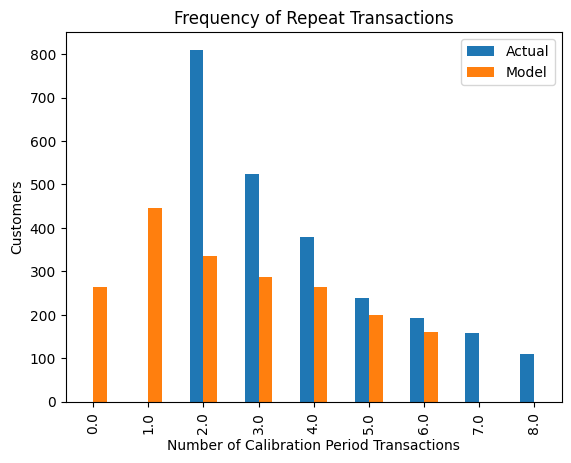

In [ ]:
#####################################################
# Tahmin Sonuçlarının Değerlendirilmesi
#####################################################

plot_period_transactions(bgf)
plt.show()

In [ ]:
#####################################################
# 3.GAMMA - GAMMA Modelinin Kurulması
#####################################################

#BG - NBD Satın Alma Sayısını Modelledi
#Gamma - Gamma average profiti modelliyor


ggf = GammaGammaFitter(penalizer_coef= 0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])


<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 3.79, q: 0.34, v: 3.73>

In [ ]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

CustomerID
12357.0000   6172.3459
17450.0000   5457.7883
14091.0000   5022.9216
14088.0000   4792.1915
18102.0000   3533.3926
12409.0000   3228.0113
14646.0000   3115.7658
12454.0000   2940.2847
16684.0000   2866.3781
12415.0000   2851.5073
dtype: float64

In [ ]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [ ]:
cltv_df.sort_values("expected_average_profit", ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
CustomerID,,,,,,,
12357.0000,0.0000,3.4286,2,5633.4650,0.2730,1.0803,6172.3459
17450.0000,10.0000,10.5714,7,5321.5850,0.4423,1.7590,5457.7883
14091.0000,6.2857,47.7143,2,4584.0450,0.0120,0.0478,5022.9216
14088.0000,2.0000,8.1429,3,4512.9900,0.2344,0.9305,4792.1915
18102.0000,53.2857,53.4286,89,3526.4424,1.4528,5.8015,3533.3926
12409.0000,20.5714,28.7143,4,3086.6550,0.1430,0.5699,3228.0113
14646.0000,51.7143,53.2857,78,3108.7672,1.2720,5.0793,3115.7658
12454.0000,3.5714,8.1429,4,2811.4450,0.3052,1.2120,2940.2847
16684.0000,50.2857,52.5714,27,2847.7670,0.4636,1.8513,2866.3781


In [ ]:
###########################################################
#4. BG - NBD ve GG Modeli ile CLTV nin Hesaplanması
###########################################################

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time = 3, #3 aylık
                                   freq="W", # T nin frekans bilgisi
                                   discount_rate=0.01)



In [ ]:
cltv.head()

CustomerID
12346.0000     20.7827
12347.0000   2224.0970
12349.0000   1133.2345
12352.0000    645.5211
12356.0000   4087.5309
Name: clv, dtype: float64

In [ ]:
cltv = cltv.reset_index()

In [ ]:
cltv_final = cltv_df.merge(cltv, on="CustomerID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,CustomerID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2827,18102.0000,53.2857,53.4286,89,3526.4424,1.4528,5.8015,3533.3926,65172.9677
1096,14646.0000,51.7143,53.2857,78,3108.7672,1.2720,5.0793,3115.7658,50314.6717
846,14156.0000,52.2857,53.4286,102,1791.7474,1.6547,6.6074,1794.8458,37705.1748
2499,17450.0000,10.0000,10.5714,7,5321.5850,0.4423,1.7590,5457.7883,30222.1098
1229,14911.0000,53.2857,53.4286,205,698.9298,3.3111,13.2220,699.5418,29407.8968
616,13694.0000,51.5714,53.0000,94,1364.9177,1.5341,6.1259,1367.4888,26632.8985
5,12357.0000,0.0000,3.4286,2,5633.4650,0.2730,1.0803,6172.3459,20801.0419
2523,17511.0000,52.7143,53.2857,31,2726.2206,0.5245,2.0944,2741.7306,18254.3748
2099,16684.0000,50.2857,52.5714,27,2847.7670,0.4636,1.8513,2866.3781,16867.4168
1300,15061.0000,53.0000,53.4286,86,938.1211,1.4041,5.6067,940.0665,16757.2940


In [ ]:
#recency değeri arttıkça satın alma işlemi artar churn drop gibi bir durum yoksa satın alma ihtiyacı yine ortaya çıkar

In [ ]:
######################################################
# 5. CLTV ye Göre Segmentlerin Oluşturulması
######################################################


In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels = ["D", "C", "B", "A"])
cltv_final.head()

,CustomerID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,segment
0,12346.0000,28.0000,51.5714,11,33.8964,0.0471,0.1880,34.7855,20.7827,D
1,12347.0000,5.2857,5.7143,2,661.6600,0.2469,0.9785,726.7538,2224.0970,A
2,12349.0000,25.8571,32.1429,3,765.0067,0.1104,0.4400,813.4300,1133.2345,A
3,12352.0000,2.2857,4.0000,2,171.9000,0.2744,1.0865,190.3223,645.5211,B
4,12356.0000,6.2857,8.5714,3,1187.4167,0.2599,1.0321,1261.8495,4087.5309,A


In [ ]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

CustomerID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_average_profit                         clv                
                  sum       mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                  sum   mean count                   sum   mean count                     sum     mean count          sum      mean count
segment                                                                                                                                                                                                                                                                             
D       11256624.0000 15547.8232   724 16283.0000 22.4903   724 29750.4286 41.0918   724      2319  3.2030   724 143032.3438 197.5585   724              48.4435 0.0669   724              193.1502 0.2668   724             154559.6980 213.4802   724  105629.6057  145.8972   724
C       11155903.0000 15430.0180   723 21714.0000 30.0332   723 27345.0000 37.8216   723      3076  4.2545   723 194544.5946 269.0797   723              88.4328 0.1223   723              352.5021 0.4876   723             207116.2951 286.4679   723  279950.1354  387.2063   723
B       11049226.0000 15282.4703   723 21738.2857 30.0668   723 25649.2857 35.4762   723      3993  5.5228   723 274697.1725 379.9408   723             118.5747 0.1640   723              472.4464 0.6535   723             289800.1854 400.8301   723  500779.5178  692.6411   723
A       10948248.0000 15142.8050   723 22807.8571 31.5461   723 25433.4286 35.1776   723      8406 11.6266   723 470244.6260 650.4075   723             205.3295 0.2840   723              818.4105 1.1320   723             489225.1300 676.6599   723 1667829.0247 2306.8175   723

#######################################################
# 6. Çalışmanın Fonksiyonlaştırılması
#######################################################
#def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["InvoiceNo"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["UnitPrice"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "UnitPrice")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["UnitPrice"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('CustomerID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'InvoiceNo': lambda InvoiceNo: InvoiceNo.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")
